PART 01

Gridworld problem parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld settings
grid_size = 5
gamma = 0.95
theta = 1e-6
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
action_indices = {(-1, 0): 0, (1, 0): 1, (0, -1): 2, (0, 1): 3}
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Special transitions: (reward, list of (probability, next_state))
special_transitions = {
    (0, 1): (5, [(1.0, (3, 2))]),  # Blue -> Red
    (0, 4): (2.5, [(0.5, (3, 2)), (0.5, (4, 4))])  # Green -> Red or Yellow
}

1.1 Estimatation the value function for each of the states solving the system of Bellman equations explicitly

Value function (Bellman equation Solution):
[[ 2.171   4.7336  2.0703  1.2653  1.7791]
 [ 1.1181  1.7821  1.1741  0.7392  0.5625]
 [ 0.1628  0.4779  0.352   0.1105 -0.1862]
 [-0.547  -0.2847 -0.2804 -0.4399 -0.7443]
 [-1.1079 -0.8494 -0.808  -0.938  -1.2372]]


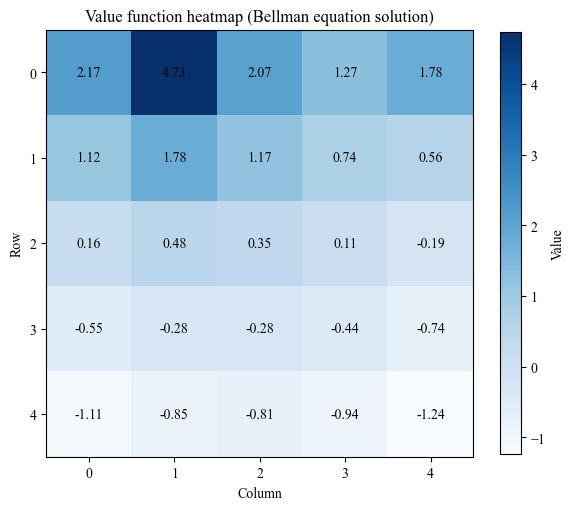

In [2]:
# Helper to convert 2D state to 1D index
def state_to_index(i, j):
    return i * grid_size + j

# Helper to check boundary
def is_within_bounds(i, j):
    return 0 <= i < grid_size and 0 <= j < grid_size

# Initialize Bellman equation system: K * V = L
num_states = grid_size * grid_size
K = np.eye(num_states)
L = np.zeros(num_states)

# Construct Bellman equations
for i in range(grid_size):
    for j in range(grid_size):
        state = (i, j)
        idx = state_to_index(i, j)

        if state in special_transitions:
            reward, outcomes = special_transitions[state]
            for prob, next_state in outcomes:
                next_idx = state_to_index(*next_state)
                K[idx, next_idx] -= gamma * prob  # weighted by transition prob
            L[idx] = reward  # fixed reward regardless of action
        else:
            for action in actions:
                ni, nj = i + action[0], j + action[1]
                if is_within_bounds(ni, nj):
                    next_state = (ni, nj)
                    next_idx = state_to_index(*next_state)
                    K[idx, next_idx] -= gamma / 4
                    L[idx] += 0 / 4  # reward is 0 for regular moves
                else:
                    K[idx, idx] -= gamma / 4  # stays in place
                    L[idx] += -0.5 / 4  # stepping off grid gets -0.5

# Solve the system
V = np.linalg.solve(K, L)
V_grid = V.reshape((grid_size, grid_size))

# Output
print("Value function (Bellman equation Solution):")
print(np.round(V_grid, 4))

# Plotting heatmap
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.imshow(V_grid, cmap='Blues', interpolation='nearest')
plt.title('Value function heatmap (Bellman equation solution)')
plt.colorbar(label='Value', shrink=0.74)
plt.xlabel('Column')
plt.ylabel('Row')

# Annotate values
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{V_grid[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()



1.2 Estimatation the value function for each of the states using iterative policy evaluation

Iterative policy evaluation for value function:
[[ 2.1728  4.7354  2.0721  1.2671  1.781 ]
 [ 1.1199  1.784   1.1759  0.741   0.5643]
 [ 0.1646  0.4797  0.3538  0.1123 -0.1843]
 [-0.5452 -0.2829 -0.2786 -0.4381 -0.7425]
 [-1.106  -0.8475 -0.8062 -0.9362 -1.2354]]


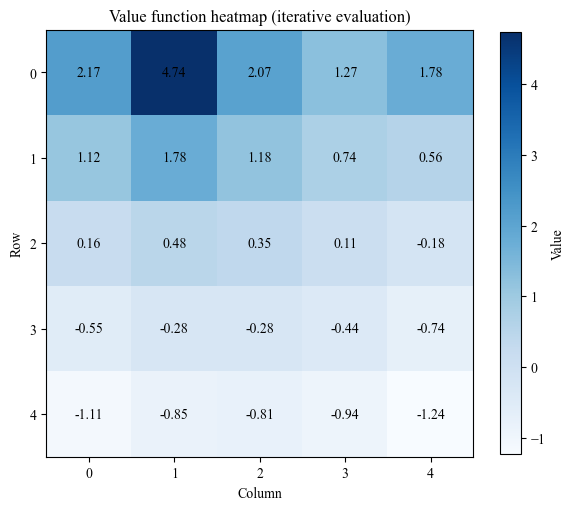

In [ ]:
# Initialize value function
V = np.zeros((grid_size, grid_size))

# Helper function to check bounds
def is_within_bounds(i, j):
    return 0 <= i < grid_size and 0 <= j < grid_size

# Iterative Policy Evaluation
def iterative_policy_evaluation(V, gamma=0.95, theta=1e-4):
    while True:
        delta = 0
        new_V = np.copy(V)
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                v = 0
                if state in special_transitions:
                    reward, transitions = special_transitions[state]
                    for prob, (ni, nj) in transitions:
                        v += prob * (reward + gamma * V[ni, nj])
                else:
                    for action in actions:
                        ni, nj = i + action[0], j + action[1]
                        if is_within_bounds(ni, nj):
                            reward = 0
                            v += 0.25 * (reward + gamma * V[ni, nj])
                        else:
                            reward = -0.5
                            v += 0.25 * (reward + gamma * V[i, j])
                new_V[i, j] = v
                delta = max(delta, abs(V[i, j] - v))
        V = new_V
        if delta < theta:
            break
    return V

# Run evaluation
V_iterative = iterative_policy_evaluation(V)

# Print result
print("Iterative policy evaluation for value function:")
print(np.round(V_iterative, 4))

# Plot heatmap
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'
im = plt.imshow(V_iterative, cmap='Blues', interpolation='nearest')
plt.colorbar(im, shrink=0.74, label='Value')
plt.title('Value function heatmap (iterative evaluation)')
plt.xlabel('Column')
plt.ylabel('Row')

# Annotate values
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{V_iterative[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


2.1 Optimal policy for the gridworld problem by explicitly solving the Bellman optimality equation

Optimal value function:
[[20.9973 22.1025 20.9973 19.9475 18.3828]
 [19.9475 20.9973 19.9475 18.9501 18.0026]
 [18.9501 19.9475 18.9501 18.0026 17.1025]
 [18.0026 18.9501 18.0026 17.1025 16.2473]
 [17.1025 18.0026 17.1025 16.2473 15.435 ]]
Optimal policy:
→ ↑ ← ← ↑
↑ ↑ ↑ ↑ ←
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑


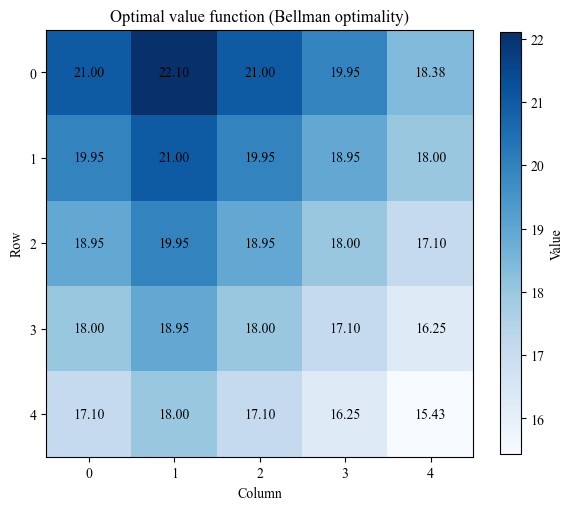

In [4]:
# Check if a state is in grid bounds
def in_bounds(i, j):
    return 0 <= i < grid_size and 0 <= j < grid_size

# Compute expected value for a given (state, action)
def get_expected_value(state, action, V):
    i, j = state

    # Handle special transitions (Blue or Green)
    if state in special_transitions:
        reward, outcomes = special_transitions[state]
        value = 0
        for prob, (ni, nj) in outcomes:
            value += prob * (reward + gamma * V[ni, nj])
        return value

    # Normal transitions
    ni, nj = i + action[0], j + action[1]
    if in_bounds(ni, nj):
        return 0 + gamma * V[ni, nj]
    else:
        return -0.5 + gamma * V[i, j]  # Penalize off-grid steps

# Bellman optimality solver (Value iteration)
def solve_bellman_optimality():
    V = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size), dtype=int)

    while True:
        delta = 0
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                v = V[i, j]
                max_value = -np.inf
                best_action = None
                for action in actions:
                    value = get_expected_value(state, action, V)
                    if value > max_value:
                        max_value = value
                        best_action = action
                V[i, j] = max_value
                policy[i, j] = action_indices[best_action]
                delta = max(delta, abs(v - max_value))
        if delta < theta:
            break
    return V, policy

# Solve for optimal value and policy
V_optimal, optimal_policy = solve_bellman_optimality()

# Display value function
print("Optimal value function:")
print(np.round(V_optimal, 4))

# Display policy arrows
print("Optimal policy:")
for i in range(grid_size):
    row = [action_symbols[optimal_policy[i, j]] for j in range(grid_size)]
    print(" ".join(row))

# Plot the optimal value function
def plot_values(V, title):
    plt.figure(figsize=(6, 6))
    im = plt.imshow(V, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, shrink=0.74, label='Value')
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')

    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f'{V[i, j]:.2f}', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

plot_values(V_optimal, "Optimal value function (Bellman optimality)")


2.2 Optimal policy for the gridworld problem by explicitly using policy iteration with iterative policy evaluation

Optimal value function by policy iteration:
[[20.9973 22.1025 20.9973 19.9475 18.3828]
 [19.9475 20.9973 19.9475 18.9501 18.0026]
 [18.9501 19.9475 18.9501 18.0026 17.1025]
 [18.0026 18.9501 18.0026 17.1025 16.2473]
 [17.1025 18.0026 17.1025 16.2473 15.435 ]]
Optimal Policy:
→ ↑ ← ← ↑
↑ ↑ ↑ ↑ ←
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑


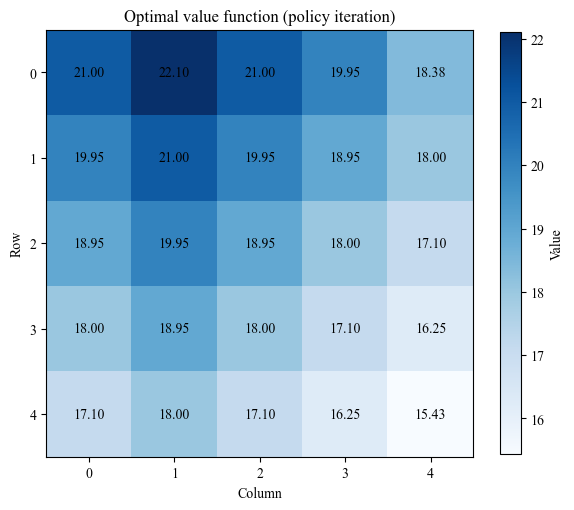

In [5]:
# Policy Evaluation
def policy_evaluation(policy, V, theta=1e-6):
    while True:
        delta = 0
        new_V = np.copy(V)
        for i in range(grid_size):
            for j in range(grid_size):
                action = actions[policy[i, j]]
                new_v = get_expected_value((i, j), action, V)
                delta = max(delta, abs(V[i, j] - new_v))
                new_V[i, j] = new_v
        V = new_V
        if delta < theta:
            break
    return V

# Policy Improvement
def policy_improvement(V, policy):
    policy_stable = True
    for i in range(grid_size):
        for j in range(grid_size):
            old_action = policy[i, j]
            max_v = -float('inf')
            best_action = None
            for action in actions:
                val = get_expected_value((i, j), action, V)
                if val > max_v:
                    max_v = val
                    best_action = action
            policy[i, j] = action_indices[best_action]
            if policy[i, j] != old_action:
                policy_stable = False
    return policy, policy_stable

# Policy Iteration
def policy_iteration():
    V = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size), dtype=int)
    while True:
        V = policy_evaluation(policy, V)
        policy, stable = policy_improvement(V, policy)
        if stable:
            break
    return V, policy

# Perform Policy Iteration
optimal_value_function, optimal_policy = policy_iteration()

# Print the optimal value function
print("Optimal value function by policy iteration:")
print(np.round(optimal_value_function, 4))

# Print the optimal policy using arrows
print("Optimal Policy:")
for i in range(grid_size):
    print(" ".join(action_symbols[optimal_policy[i, j]] for j in range(grid_size)))

# Plotting function
def plot_values(V, title):
    plt.figure(figsize=(6, 6))
    im = plt.imshow(V, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, shrink=0.74, label='Value')
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f'{V[i, j]:.2f}', ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

# Plot the value function
plot_values(optimal_value_function, "Optimal value function (policy iteration)")

2.3 Optimal policy for the gridworld problem by explicitly using policy improvement with value iteration

Optimal value function by value iteration:
[[20.9973 22.1025 20.9973 19.9475 18.3828]
 [19.9475 20.9973 19.9475 18.9501 18.0026]
 [18.9501 19.9475 18.9501 18.0026 17.1025]
 [18.0026 18.9501 18.0026 17.1025 16.2473]
 [17.1025 18.0026 17.1025 16.2473 15.435 ]]
Optimal Policy:
→ ↑ ← ← ↑
↑ ↑ ↑ ↑ ←
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑


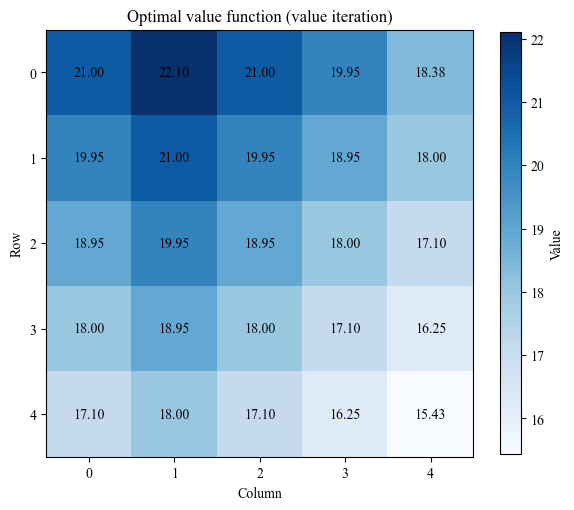

In [7]:
# Gridworld parameters
grid_size = 5
gamma = 0.95
theta = 1e-6
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
action_indices = {(-1, 0): 0, (1, 0): 1, (0, -1): 2, (0, 1): 3}
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Special transitions with probabilities
special_transitions = {
    (0, 1): (5, [(1.0, (3, 2))]),                 # Blue → Red
    (0, 4): (2.5, [(0.5, (3, 2)), (0.5, (4, 4))])  # Green → Red or Yellow
}
# Value Iteration
def value_iteration(V, theta=1e-6):
    while True:
        delta = 0
        new_V = np.copy(V)
        for i in range(grid_size):
            for j in range(grid_size):
                max_v = max(get_expected_value((i, j), action, V) for action in actions)
                delta = max(delta, abs(V[i, j] - max_v))
                new_V[i, j] = max_v
        V = new_V
        if delta < theta:
            break
    return V

# Policy Improvement from Value Function
def policy_improvement(V):
    policy = np.zeros((grid_size, grid_size), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            max_v = -np.inf
            best_action = None
            for action in actions:
                val = get_expected_value((i, j), action, V)
                if val > max_v:
                    max_v = val
                    best_action = action
            policy[i, j] = action_indices[best_action]
    return policy

# Run value iteration then policy improvement
V_optimal = value_iteration(np.zeros((grid_size, grid_size)))
optimal_policy = policy_improvement(V_optimal)

# Print optimal value function
print("Optimal value function by value iteration:")
print(np.round(V_optimal, 4))

# Print optimal policy using arrows
print("Optimal Policy:")
for i in range(grid_size):
    print(" ".join(action_symbols[optimal_policy[i, j]] for j in range(grid_size)))

# Plotting function
def plot_values(V, title):
    plt.figure(figsize=(6, 6))
    im = plt.imshow(V, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, shrink=0.74, label='Value')
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

# Plot result
plot_values(V_optimal, "Optimal value function (value iteration)")